# Figure 7: Model comparison

In [1]:
from setup_nb import *

In [2]:
from detector.implementations import TwoQ, FourQ
from detector.stimulus import FastDiscretePhi, fast_discrete_phi

### Simulations

#### Parameters

In [3]:
dt = 0.001  # in s

lam = 90.0
duration = 10.0
start = 0.5
stop = 9.5

contrast = 0.25
offset = 1.3

recfield = 240.0
delta_phi = 4.0

param_velo = np.logspace(0, 3, base=10, num=20)  # in deg/s

lps = np.logspace(-2, 0, base=10, num=15)
hps = np.logspace(-2, 0, base=10, num=15)

#### Detectors

In [4]:
tau_hp = 0.25
tau_lp = 0.05

d_2q = TwoQ(tau_hp=(tau_hp, tau_hp), tau_lp=(tau_lp, tau_lp), dc=(0.0, 0.0), dt=dt)
d_2q_dc = TwoQ(tau_hp=(tau_hp, tau_hp), tau_lp=(tau_lp, tau_lp), dc=(0.1, 0.1), dt=dt)

d_4q = FourQ(tau_hp=tau_hp, tau_lp=tau_lp, dc=0.0, dt=dt)
d_4q_dc = FourQ(tau_hp=tau_hp, tau_lp=tau_lp, dc=0.1, dt=dt)

#### Run

In [5]:
def run(detector, flip):
    
    # CAREFUL: Refers to global params!
    
    sys.stdout.write("\n"); sys.stdout.flush()
    
    c = []
    for velo in param_velo:
        stim = FastDiscretePhi(lam=lam, duration=duration, start=start, stop=stop, nd=False,
                               flip=flip, vel=velo).render(recfield, delta_phi, dt)
        stim = np.maximum(contrast * stim + offset, 0)
        
        output = detector.detect(stim)
        c.append(output.mean())
        sys.stdout.write("."); sys.stdout.flush()
        
    c = np.array(c)
    return np.array(c)

In [33]:
def run2(detector, flip):
    
    base_args = {
        "duration": duration,
        "start": start,
        "stop": stop,
        "lam": lam,
        "jump_width": delta_phi,
        "phase_motion": 0.0,
        "phase_flicker": 0.5,
        "recfield": recfield,
        "delta_phi": delta_phi,
        "dt": 0.001,
    }
            
    sys.stdout.write("\n"); sys.stdout.flush()
    
    c = []
    for velo in param_velo:
        
        f_motion = velo / delta_phi
        f_flicker = f_motion if flip else 0.0
        
        stim = fast_discrete_phi(f_motion=f_motion, f_flicker=f_flicker, **base_args)
        stim = np.maximum(contrast * stim + offset, 0)
        
        output = detector.detect(stim)
        c.append(output.mean())
        sys.stdout.write("."); sys.stdout.flush()
        
    c = np.array(c)
    return np.array(c)

In [34]:
phi_2q = run(d_2q, False)
rphi_2q = run(d_2q, True)

phi_2q_dc = run(d_2q_dc, False)
rphi_2q_dc = run(d_2q_dc, True)

phi_4q = run(d_4q, False)
rphi_4q = run(d_4q, True)

phi_4q_dc = run(d_4q_dc, False)
rphi_4q_dc = run(d_4q_dc, True)

phi_2q_dc_oop = run2(d_2q_dc, False)
rphi_2q_dc_oop = run2(d_2q_dc, True)


....................
....................
....................
....................
....................
....................
....................
....................
....................
....................

In [8]:
# Full matrix:

def run_tau_matrix_generic(param_tau, param_velo, d_builder, flip=True):
    
    sys.stdout.write("\n"); sys.stdout.flush()
    
    output = np.zeros((param_tau.shape[0], param_velo.shape[0]))
    
    for idx1, tau in enumerate(param_tau):
        for idx2, velo in enumerate(param_velo):

            stim = FastDiscretePhi(lam=lam, duration=duration, start=start, stop=stop, nd=False,
                                       flip=flip, vel=velo).render(recfield, delta_phi, dt)
            stim = np.maximum(contrast * stim + offset, 0)
            
            d = d_builder(tau)
            
            output[idx1, idx2] = d.detect(stim).mean()
            sys.stdout.write("."); sys.stdout.flush()
            
    return output / np.abs(output).max()

In [9]:
builder_2q_lp = lambda tau: TwoQ(tau_lp=(tau, tau), tau_hp=(tau_hp, tau_hp), dc=(0.1, 0.1), dt=dt)
builder_2q_hp = lambda tau: TwoQ(tau_hp=(tau, tau), tau_lp=(tau_lp, tau_lp), dc=(0.1, 0.1), dt=dt)

builder_4q_lp = lambda tau: FourQ(tau_hp=tau_hp, tau_lp=tau, dc=0.0, dt=dt)
builder_4q_hp = lambda tau: FourQ(tau_hp=tau, tau_lp=tau_lp, dc=0.0, dt=dt)

In [10]:
mat_4q_lp = run_tau_matrix_generic(lps, param_velo, builder_4q_lp, flip=True)
mat_4q_hp = run_tau_matrix_generic(hps, param_velo, builder_4q_hp, flip=True)

mat_2q_lp = run_tau_matrix_generic(lps, param_velo, builder_2q_lp, flip=True)
mat_2q_hp = run_tau_matrix_generic(hps, param_velo, builder_2q_hp, flip=True)


............................................................................................................................................................................................................................................................................................................
............................................................................................................................................................................................................................................................................................................
............................................................................................................................................................................................................................................................................................................
................................................................................................

### Panels

In [11]:
def panel_parameter_search(output, taus, velos, filt, ax, cax=None, annot=False):
    
    m = np.abs(output).max()
    
    t, v = np.meshgrid(velos, taus)
    pc = ax.pcolormesh(t, v, output, cmap="PRGn", vmin=-m, vmax=m, linewidth=0, rasterized=True)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlim([velos[0], velos[-1]])
    ax.set_ylim([taus[0], taus[-1]])
    ax.set_xticks([1, 10, 100, 1000])
    
    ax.set_ylabel("{0}-pass time\nconstant (s)".format(filt), labelpad=2.0)
    ax.set_xlabel(u"Pattern speed (°/s)", labelpad=2.0)
    
    ax.minorticks_off()
    
    if cax:
        cb = sb.plt.colorbar(pc, cax=cax)
        cb.set_label("Response to\nreverse-phi (a.u.)", labelpad=0.5)
        cb.set_ticks([-1, 0, 1])
        cax.tick_params(axis='both', which='major', pad=2)

    if filt is "High":
        loc = 0.25
    elif filt is "Low":
        loc = 0.05
    
    if annot:
        ax.annotate("",
                    xy=(1, loc), xycoords='data',
                    xytext=(5, loc), textcoords='data',
                    arrowprops=dict(arrowstyle="-|>", linewidth=1.0, facecolor="black"))
    
    sb.despine(ax=ax)

In [36]:
def panel_summary(tuning1, tuning2, ax, legend=False):
    
    m = np.max([np.abs(tuning1).max(), np.abs(tuning2).max()])
    tuning1, tuning2 = tuning1 / m, tuning2 / m
    
    lw = 1.0
    ax.plot(param_velo, tuning1, color=gt_colors[0.0], label=u"Phi (λ = 90°)", linewidth=lw)
    ax.plot(param_velo, tuning2, color=gt_colors[1.0], label="Reverse-phi", linewidth=lw)
    
    ax.set_xscale('log')
    ax.set_xlim([param_velo[0], param_velo[-1]])
    ax.set_xticks([1, 10, 100, 1000])
    ax.set_ylim([-0.7, 1.2])
    ax.set_yticks([-0.5, 0, 0.5, 1])
    ax.set_ylabel("Normalized mean\nresponse (a.u.)", labelpad=2.5)
    ax.set_xlabel(u"Pattern speed (°/s)", labelpad=4.0)
    
    sb.plt.minorticks_off()
    
    if legend:
        ax.legend(loc=(0.05, -0.23))
    
    add_refline(ax, horizontal=True)
    
    sb.despine(ax=ax)

In [28]:
def model_figure():
        
    off = 2.0
    off_v = -17.3
    rows = [0, 2.5, 5.0, 7.5]
    panelsize = (2, 2)

    fig = sb.plt.figure(figsize=(4.85, 3.8))

    # Phi model:
    height = 24 + off_v
    
    ax = addaxis(fig, (off + rows[0], height), panelsize, letter="a", nudge=0.5)
    panel_summary(phi_4q, rphi_4q, ax, legend=True)
    ax.set_title("4Q")
    remove_axis(ax, x=True)    
    
    ax = addaxis(fig, (off + rows[1], height), panelsize, letter="b", nudge=0)
    panel_summary(phi_2q_dc, rphi_2q_dc, ax, legend=False)
    ax.set_title("2Q")
    remove_axis(ax, x=True, y=True)    

    ax = addaxis(fig, (off + rows[2], height), panelsize, letter="c", nudge=0)
    panel_summary(phi_2q, rphi_2q, ax, legend=False)
    ax.set_title("2Q\nwithout DC")
    remove_axis(ax, y=True)
    
    ax = addaxis(fig, (off + rows[3], height), panelsize, letter="d")
    panel_summary(phi_4q_dc, rphi_4q_dc, ax, legend=False)
    ax.set_title("4Q\nwith DC")
    remove_axis(ax, x=True, y=True)
    
    height = 21.4 + off_v
    
    ax = addaxis(fig, (off + rows[0], height), panelsize, letter="f", nudge=0.5)
    panel_parameter_search(mat_4q_lp, lps, param_velo, "Low", ax, annot=True)
    remove_axis(ax, x=True)    

    ax = addaxis(fig, (off + rows[1], height), panelsize, letter="g", nudge=0.0)
    panel_parameter_search(mat_2q_lp, lps, param_velo, "Low", ax)
    remove_axis(ax, x=True, y=True)
    
    ax = addaxis(fig, (off + rows[3], height - 0.85), panelsize, letter="e", nudge=0.0)
    panel_summary(phi_2q_dc_oop, rphi_2q_dc_oop, ax, legend=False)
    ax.set_title("2Q\nout-of-phase")
    
    height = 18.8 + off_v
    
    ax = addaxis(fig, (off + rows[0], height), panelsize, letter="h", nudge=0.5)
    panel_parameter_search(mat_4q_hp, hps, param_velo, "High", ax, annot=True)

    ax = addaxis(fig, (off + rows[1], height), panelsize, letter="i", nudge=0.0)
    cax = addaxis(fig, (off + rows[2] - 0.3, height), (0.2, 2.0), letter="")
    panel_parameter_search(mat_2q_hp, hps, param_velo, "High", ax, cax=cax)
    remove_axis(ax, y=True)
    
    fig.set_frameon(False)
    fig.savefig("../output/Fig7.tif", format="tiff", dpi=standard_dpi)

### Plot

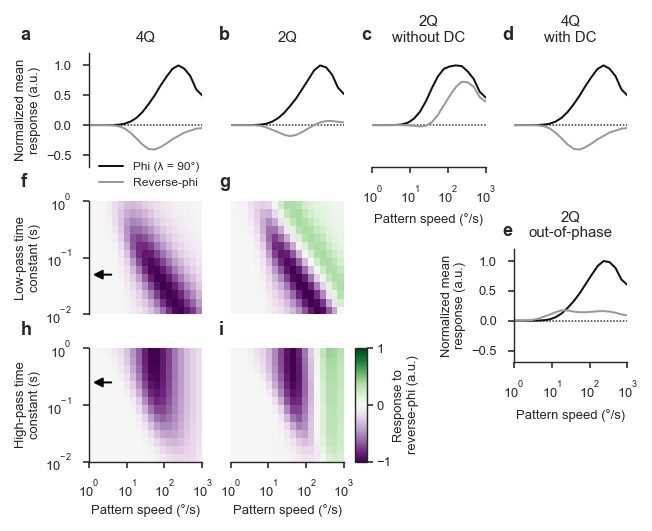

In [37]:
model_figure()